Building an Image Classifier model from scratch

#Setup

In [75]:
import kagglehub
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, load_img, img_to_array

import os
import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras.regularizers import l2


path = r".\kagglehub\datasets\andrewmvd\medical-mnist\versions\1"

print(path)
# checking if the file location is recognized
print(os.path.isdir(path))

.\kagglehub\datasets\andrewmvd\medical-mnist\versions\1
True


# Load a dataset

In [76]:
# Generating and preparing the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True)


# taking small batch to keep as validation data
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(64, 64),  # images should be 64x64 by default
    color_mode="grayscale",  # leave it grayscale
    batch_size=32,
    class_mode='categorical',
    # for multi-class classification, didn't want to copy the dir like I had in earlier versions
    subset="training")


# validation data
validation_generator = validation_datagen.flow_from_directory(
    path,
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=32,
    class_mode='categorical',
    # multi-classification, seperating data while running rather than before
    subset="validation")

Found 58954 images belonging to 6 classes.
Found 11790 images belonging to 6 classes.


# Build a neural network model

In [77]:

# define model using Sequential API
model = Sequential([
   ## first convolutional layer, image shape is 64x64 with grayscale (1)
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  
    MaxPooling2D((2, 2)),
    Dropout(0.3), #randomly disabiling neurons during training to prevent overfitting
    # apply 32 filters of size 3x3 to the input
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # second convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    # second convolutional layer, further reduces spatial dimensions
    MaxPooling2D((2, 2)),
    Flatten(),  # flatten from 3D feature maps to a 1D vector
    # Dense layer with 128 neurons, relu introduces non-linearity
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation = "relu"),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Output layer with 6 classes
])


c:\Users\seaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [78]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,270 (2.64 MB)

 Trainable params: 691,270 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

#compiling the model:


In [79]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [80]:
"""# check the output of flow_from_directory
print(f"Train generator classes: {train_generator.class_indices}")
print(f"Validation generator classes: {validation_generator.class_indices}")

# check batch sizes and data shapes
for batch, labels in train_generator:
    print(f"Batch shape: {batch.shape}, Label shape: {labels.shape}")
    break  # just inspect the first batch"""

'# check the output of flow_from_directory\nprint(f"Train generator classes: {train_generator.class_indices}")\nprint(f"Validation generator classes: {validation_generator.class_indices}")\n\n# check batch sizes and data shapes\nfor batch, labels in train_generator:\n    print(f"Batch shape: {batch.shape}, Label shape: {labels.shape}")\n    break  # just inspect the first batch'

# training neural network model:


In [81]:
#training time 
history = model.fit(train_generator, epochs=5, validation_data = validation_generator, shuffle=True)

c:\Users\seaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 1329s 720ms/step - accuracy: 0.7360 - loss: 0.8493 - val_accuracy: 0.9889 - val_loss: 0.1222
Epoch 2/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 727s 395ms/step - accuracy: 0.9673 - loss: 0.2004 - val_accuracy: 0.9754 - val_loss: 0.1445
Epoch 3/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 614s 333ms/step - accuracy: 0.9706 - loss: 0.1765 - val_accuracy: 0.9943 - val_loss: 0.0714
Epoch 4/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 317s 172ms/step - accuracy: 0.9828 - loss: 0.1249 - val_accuracy: 0.9969 - val_loss: 0.0697
Epoch 5/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.9896 - loss: 0.0937 - val_accuracy: 0.9970 - val_loss: 0.0620


#Evaluation



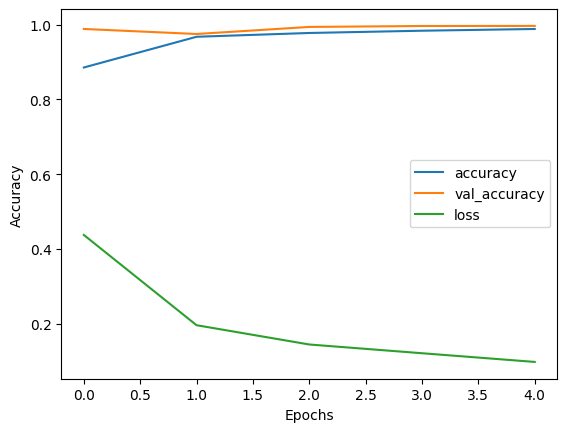

369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9977 - loss: 0.0599
Test Accuracy: 0.9970313906669617


In [87]:
# plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# save the model
model.save('image_classifier_model.h5')

# test the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_accuracy}')


In [83]:
# Checking if value exists
"""print(val_dir)
print(os.path.exists(val_dir + r"\HeadCT\000019.jpeg"))

print(f"{model.input_shape}")
print(img_array.shape)"""

'print(val_dir)\nprint(os.path.exists(val_dir + r"\\HeadCT\x00019.jpeg"))\n\nprint(f"{model.input_shape}")\nprint(img_array.shape)'

# Predicting a test image





In [84]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = path + r"\HeadCT\000018.jpeg"
img = image.load_img(img_path, target_size=(64, 64), color_mode = "grayscale")
img_array = image.img_to_array(img) 
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

img_array /= 255.0

print(img_array.shape) # shape should be (1, 64, 64, 1)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f'Predicted Class: {predicted_class}')




(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Predicted Class: 5


# Random Image from each category, along with the model prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


<Figure size 720x240 with 0 Axes>

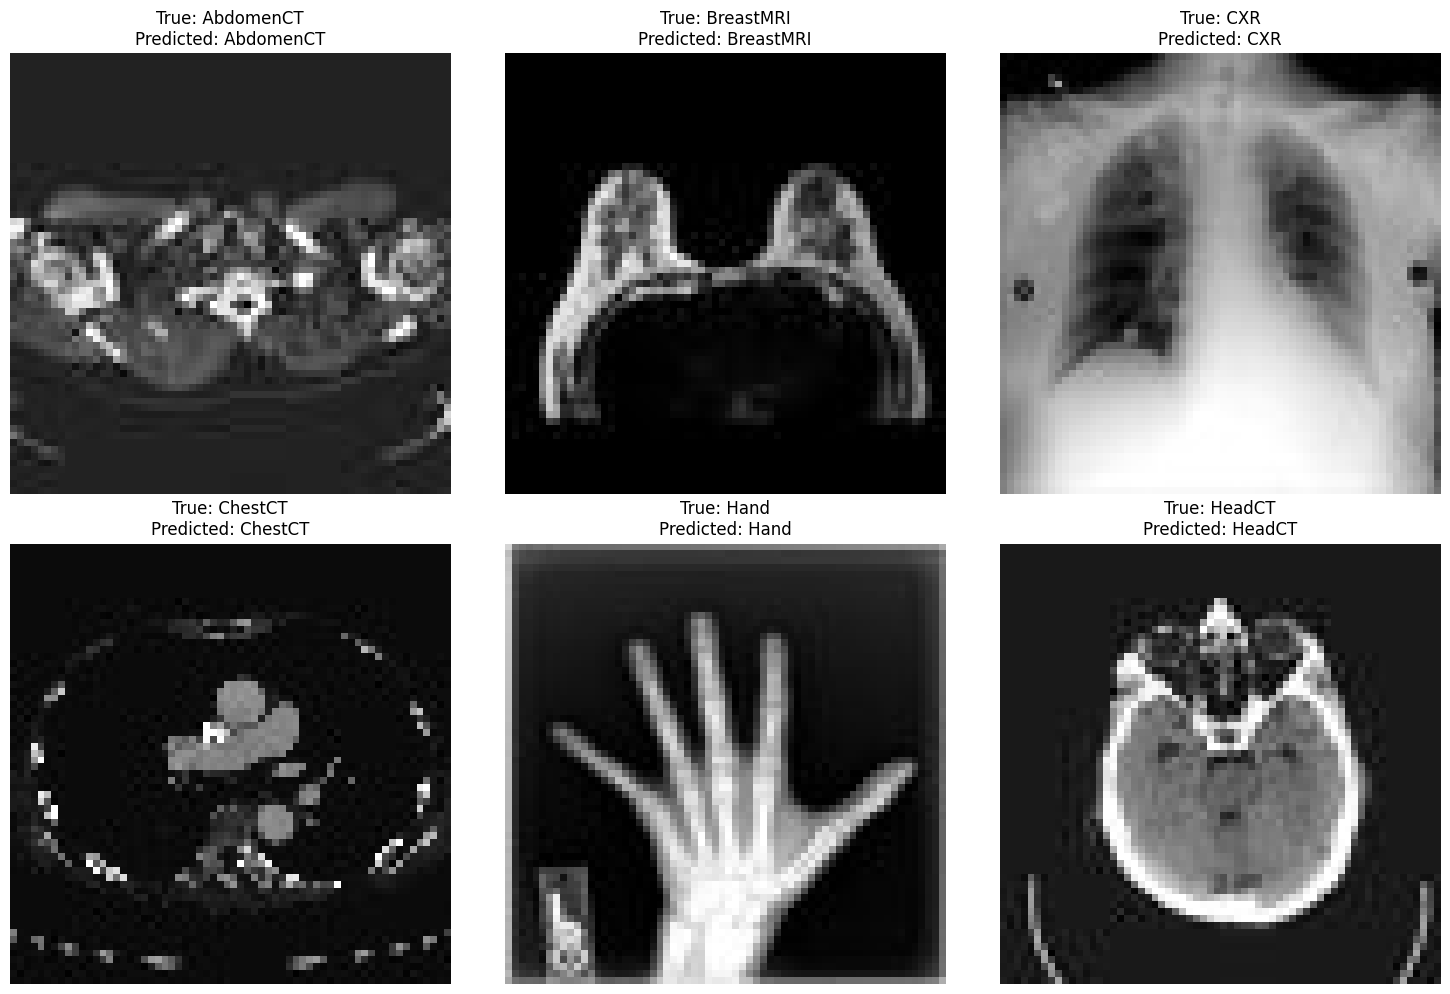

In [90]:
import random
plt.figure(figsize=(7.2, 2.4))
base_dir = path

classes = ["AbdomenCT", "BreastMRI", "CXR","ChestCT",  "Hand", "HeadCT"]

fig, axes = plt.subplots(2 ,3, figsize = (15, 10))

axes = axes.flatten()

for i, cls in enumerate(classes):
    class_dir = f"{base_dir}/{cls}"
    img_name = random.choice(os.listdir(class_dir))
    img_path = f"{class_dir}/{img_name}"

    #  preprocess the image
    img = load_img(img_path, target_size=(64, 64), color_mode='grayscale')
    img_array = img_to_array(img)  # Shape: (64, 64, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 64, 64, 1)
    img_array = img_array / 255.0  # Normalize

    #  prediction from the model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = classes[predicted_class]

    # Plot image
    axes[i].imshow(img_array.squeeze(), cmap='gray')  #  extra dimension for display
    axes[i].set_title(f"True: {cls}\nPredicted: {predicted_label}")
    axes[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()  